In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_triplicated_data_for_time_alignment(df, alignment_col):
    """

    """

    rel_points = df[df[alignment_col] > 0].reset_index()
    # print(rel_points)

    identifiers = rel_points[['index', 'nTrial', 'nEndTrial']].dropna().values.astype(int)
    if len(identifiers) == 0:
        return pd.DataFrame(columns=df.reset_index().columns)

    # print('identifiers')
    # print(identifiers)
    

    lst_extendeds = []
    
    for idx, nTrial, nEndTrial in identifiers:
        extended_trial = df[(df['nTrial'] == nTrial) | (df['nEndTrial'] == nEndTrial)].reset_index().copy()
        extended_trial['index'] -= idx

        # print('extended_trial')
        # print(extended_trial)

        lst_extendeds.append(extended_trial.copy())
        
    relative_df = pd.concat(lst_extendeds)
    return relative_df

In [3]:
df = pd.read_csv('/Users/josh/Desktop/investigation/fig2-single-individ-ft_WT63_11082021_best_resids_R2_0.5419.csv')

In [4]:
df['photometrySideInIndex'] = df['photometrySideInIndexr'] + df['photometrySideInIndexnr']
df['nEndTrial'] = np.nan
df.loc[df['wi_trial_keep'] == False, 'nEndTrial'] = df.loc[df['wi_trial_keep'] == False, 'nTrial']
df.loc[df['wi_trial_keep'] == True, 'nEndTrial'] = df.loc[df['wi_trial_keep'] == True, 'nTrial'] - 1
rl_df = get_triplicated_data_for_time_alignment(df, 'photometrySideInIndex')

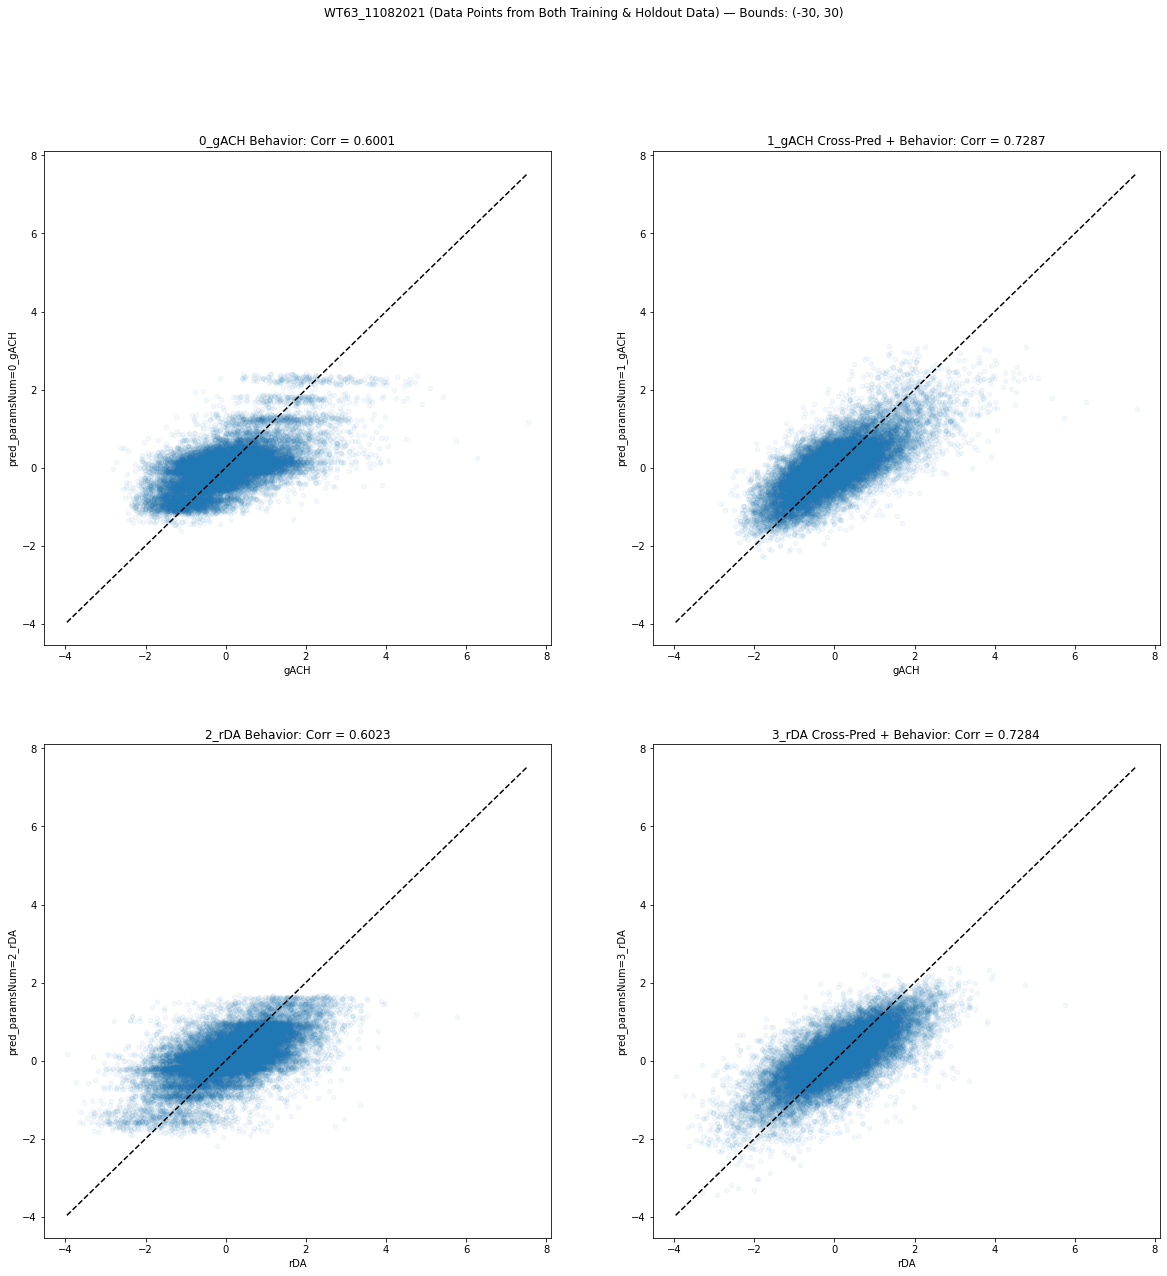

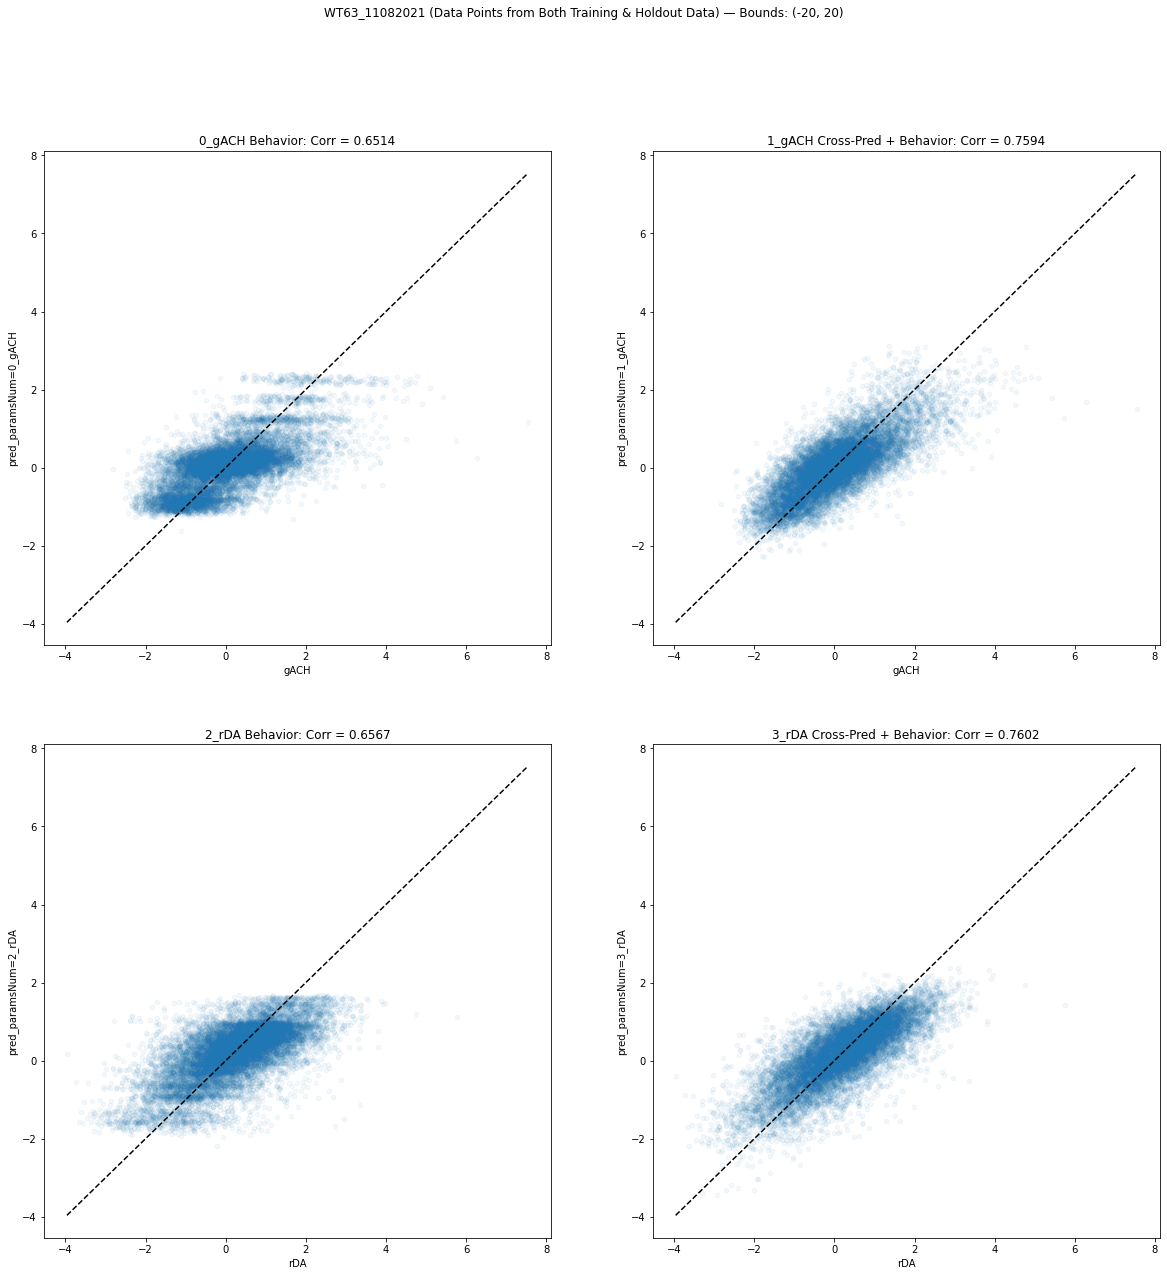

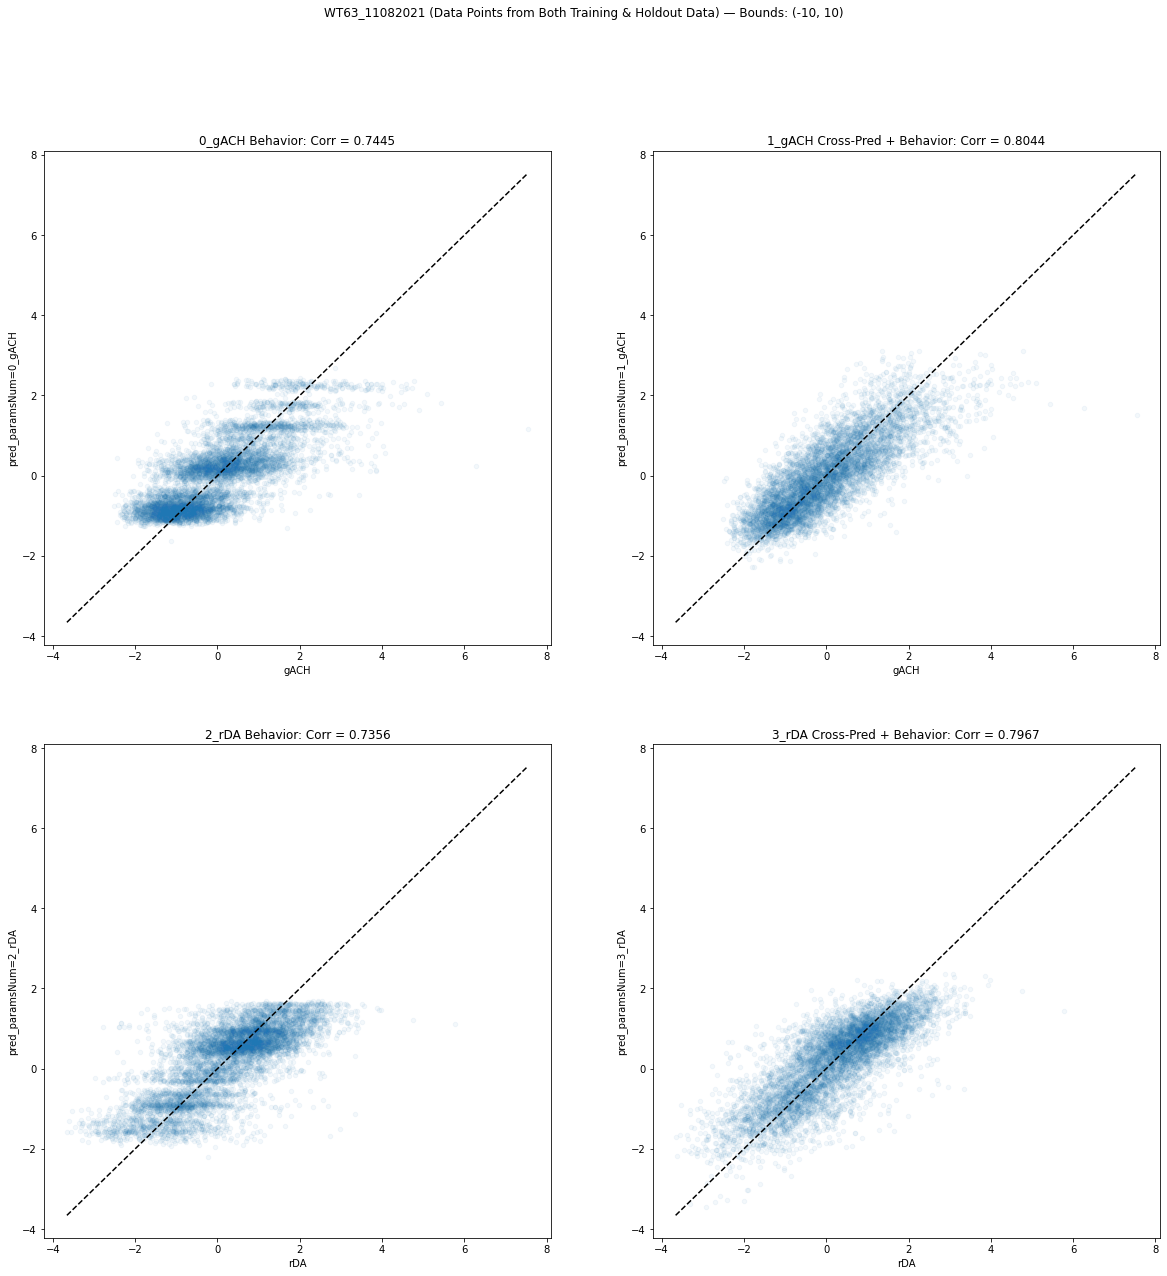

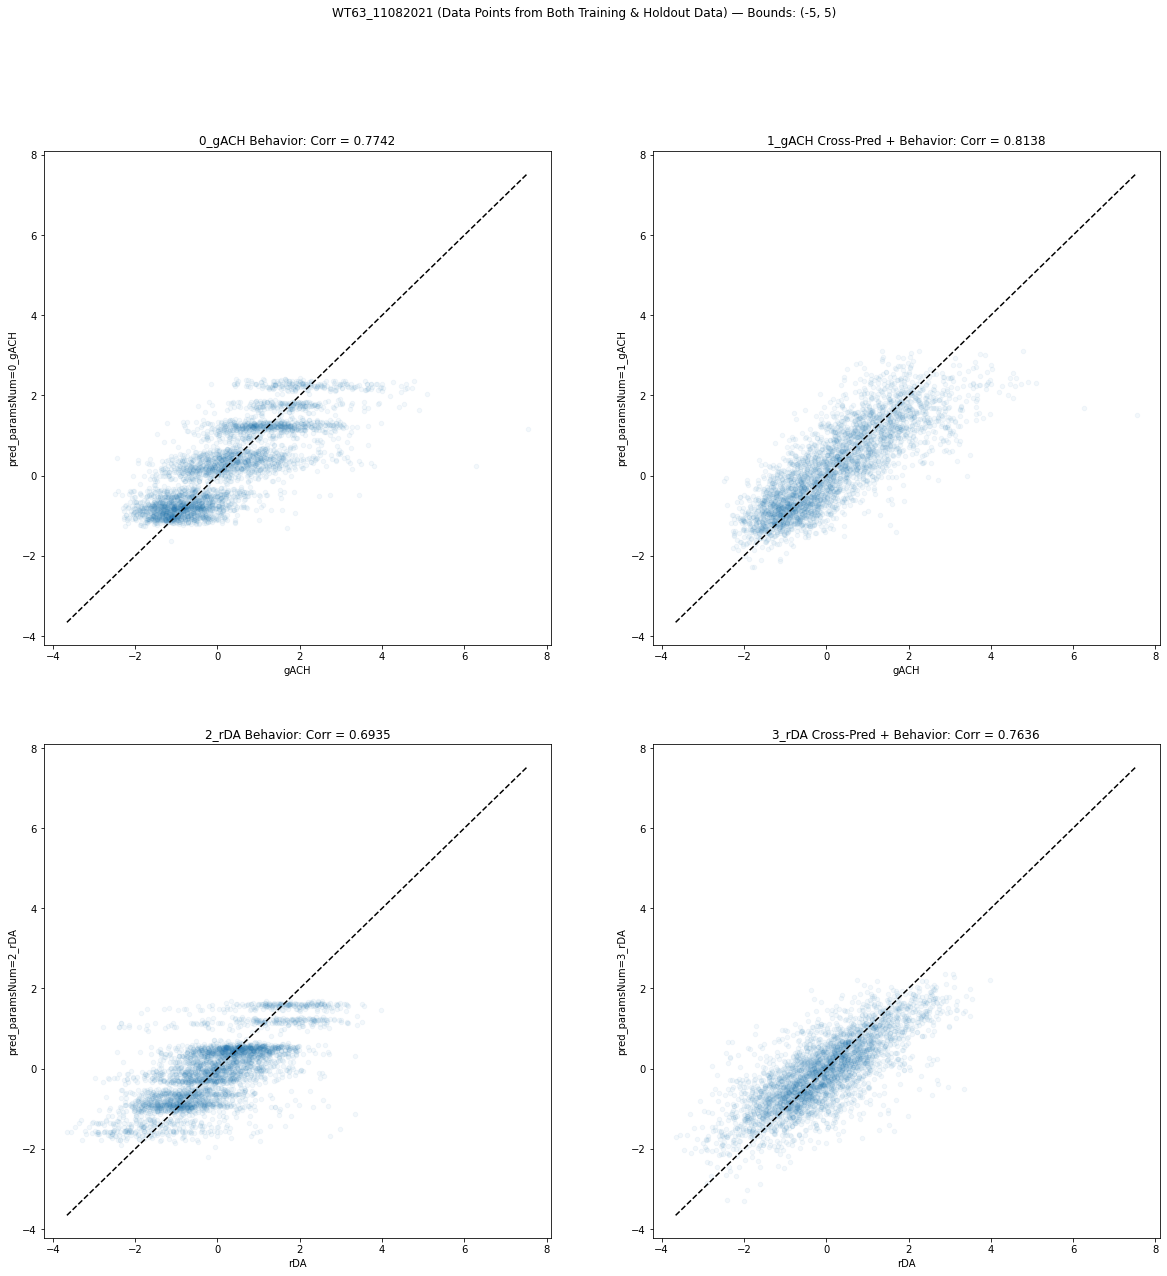

In [9]:
for bounds in [[-30, 30], [-20, 20], [-10, 10], [-5, 5],
               [0, 30], [0, 20], [0, 10], [0, 5],
              ]:
    pairwise = rl_df[rl_df['index'].between(bounds[0], bounds[1])][['index', 'gDA', 'gACH', 'rDA',
                                                                    'pred_paramsNum=0_gACH', 'pred_paramsNum=1_gACH',
                                                                    'pred_paramsNum=2_rDA', 'pred_paramsNum=3_rDA']]
    pairs = [
            ['gACH', 'pred_paramsNum=0_gACH'],
            ['gACH', 'pred_paramsNum=1_gACH'],
            ['rDA', 'pred_paramsNum=2_rDA'],
            ['rDA', 'pred_paramsNum=3_rDA'],
        ]

    bound_min = np.inf
    bound_max = -np.inf
    for pair_cols in pairs:
        x, y = pair_cols[0], pair_cols[1]
        min_val = min(np.min(pairwise[x]), np.min(pairwise[y]))
        max_val = max(np.max(pairwise[x]), np.max(pairwise[y]))

        if min_val < bound_min:
            bound_min = min_val
        if max_val > bound_max:
            bound_max = max_val

    basis_line = np.linspace(bound_min, bound_max)

    fig, ax = plt.subplots(2,2,figsize=(20,20), facecolor='white')
    fig.suptitle(f'WT63_11082021 (Data Points from Both Training & Holdout Data) — Bounds: ({bounds[0]}, {bounds[1]})')
    for ip, pair_cols in enumerate(pairs):
        tmp_ax = ax[ip//2, ip%2]

        x, y = pair_cols[0], pair_cols[1]

        tmp_pair = pairwise[pair_cols].copy()
        corr = np.round(tmp_pair.corr().iloc[0,1], 4)
        
        info = y.split('=')[-1]
        if int(info[0]) % 2 == 1:
            info += ' Cross-Pred + Behavior'
        else:
            info += ' Behavior'

        tmp_pair.plot.scatter(x, y, alpha=0.05, ax=tmp_ax)
        tmp_ax.plot(basis_line, basis_line, c='k', linestyle='--')
        tmp_ax.set_title(f'{info}: Corr = {corr}')
    fig.savefig(f'/Users/josh/Desktop/investigation/corr_analysis_WT63_11082021_bnd={bounds[0]}_{bounds[1]}.png')